# [ML Mid Assignment] Decision Tree 
2018204094 박형빈

의사결정나무의 알고리즘 분석 수행 

알고리즘은 CART 알고리즘을 기반으로 적용하며, 모델의 적합, 평가, 그리고 일반화 성능을 높이기 위한 가지치기까지 수행해본다.

*주석, Markdown 부분을 통해 결과를 해석하고 코드에 대한 설명을 첨부하였습니다* 

# 1.1 Data Load

original data -> amphibians

이번 의사결정나무 분석 수행을 위한 데이터셋은 **GIS 시스템 및 위성 이미지를 기반한 양서류 종 예측 데이터**입니다.  

해당 데이터셋은 지역적인 특성을 기반으로 어떤 양서류 종이 나타나는지 예측하기 위해 만들어졌지만,  
지역의 특성과 나타나는 양서류 종에 기반하여 어느 지역인지(Motorway) 예측하도록 하겠습니다. 
(이유는 하단에서 자세히 서술)

[https://archive.ics.uci.edu/ml/datasets/Amphibians]

In [117]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import export_graphviz # tree 시각화를 위해
# export_graphviz : 의사결정나무에 대한 graphviz dot data 생성하는 함수
import graphviz # tree 시각화
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate 

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "./Dataset/"

amphibians = pd.read_csv(path+"Amphibians.csv", delimiter = ';', header = 1)

# original data -> amphibians
amphibians

,ID,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,...,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,1,A1,600,1,1,4,6,2,10,0,...,0,0,1,0,0,0,0,0,0,0
1,2,A1,700,1,5,1,10,6,10,3,...,1,0,1,0,1,1,0,0,1,0
2,3,A1,200,1,5,1,10,6,10,3,...,1,0,1,0,1,1,0,0,1,0
3,4,A1,300,1,5,0,6,10,2,3,...,0,0,1,0,0,1,0,0,0,0
4,5,A1,600,2,1,4,10,2,6,0,...,5,0,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,185,S52,2300,1,12,3,2,2,1,0,...,1,0,1,0,1,0,0,0,0,0
185,186,S52,300,1,14,2,7,10,2,0,...,5,0,1,1,1,1,1,0,1,0
186,187,S52,500,1,1,4,1,10,2,0,...,5,0,1,1,1,1,1,0,1,0
187,188,S52,300,1,12,3,2,1,6,0,...,0,0,1,0,1,1,0,0,0,0


In [3]:
amphibians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  189 non-null    int64 
 1   Motorway            189 non-null    object
 2   SR                  189 non-null    int64 
 3   NR                  189 non-null    int64 
 4   TR                  189 non-null    int64 
 5   VR                  189 non-null    int64 
 6   SUR1                189 non-null    int64 
 7   SUR2                189 non-null    int64 
 8   SUR3                189 non-null    int64 
 9   UR                  189 non-null    int64 
 10  FR                  189 non-null    int64 
 11  OR                  189 non-null    int64 
 12  RR                  189 non-null    int64 
 13  BR                  189 non-null    int64 
 14  MR                  189 non-null    int64 
 15  CR                  189 non-null    int64 
 16  Green frogs         189 no

# 1.2 EDA 

**GIS 시스템 및 위성 이미지를 기반한 양서류 종 예측 데이터**

**189 rows X 23 columns**

- **식별자 변수**
    - ID
- **범주형 변수** 
    - **명목형 변수 Nominal Variable** 
    - TR, Type of water reservoirs 저수지 유형(8)
    - VR, Presence of vegetation within the reservoirs 저수지 내 초목 존재(5)
    - UR, Use of water reservoirs 저수지 사용
    - FR, The presence of fishing 어업의 존재
    - MR, Maintenance status of the reservoir 저수지의 유지 관리 상태
    - CR, Type of shore 해안의 유형
    - SUR1, SUR2, SUR3, Surroundings 저수지 주변 토지 정보
    - Amphibians label 출현하는 양서류 종류 (7)
        - Green frogs, Brown frogs, Common toad, Fire-bellied toad, Tree frog, Common newt, Great crested newt
    - **순서형 변수 Ordinary Variable** 
    - RR, Minimum distance from the water reservoir to roads 저수지에서 도로까지의 최소 거리 
    - BR, Building development 개발 건물까지의 최소 거리 
- **연속형 변수** 
    - SR, Surface of water reservoir numeric, m2 저수지 면적
    - NR, Number of water reservoirs in habitat 서식지의 저수지 수
    - OR, Percentage access from the edges of the reservoir to undeveloped areas 저수지 가장자리에서 미개발 지역까지의 접근 비율
    
- **y 변수** 
    - MV, motorway 고속도로(2) 
    - 원래는 지역에 기반하여 나타나는 양서류 종을 예측해야 하지만, 나타나는 양서류 종에 따른 지역을 예측하도록 하였음 
        - 양서류 종을 맞추기에는 class가 너무 많음 (8개)
        - 그에 비해 데이터 수는 너무 적음 (189개)
        - 즉, label 8개인 multi-class classification 문제에 대해 데이터가 150개가량 되므로 underfitting이 되기에 accuracy가 0.3밖에 나오지 않음 
        - 지금은 의사결정나무에 대한 분석이 목표이므로 y변수를 바꾸어서 풀어보기로 하였다

<AxesSubplot:>

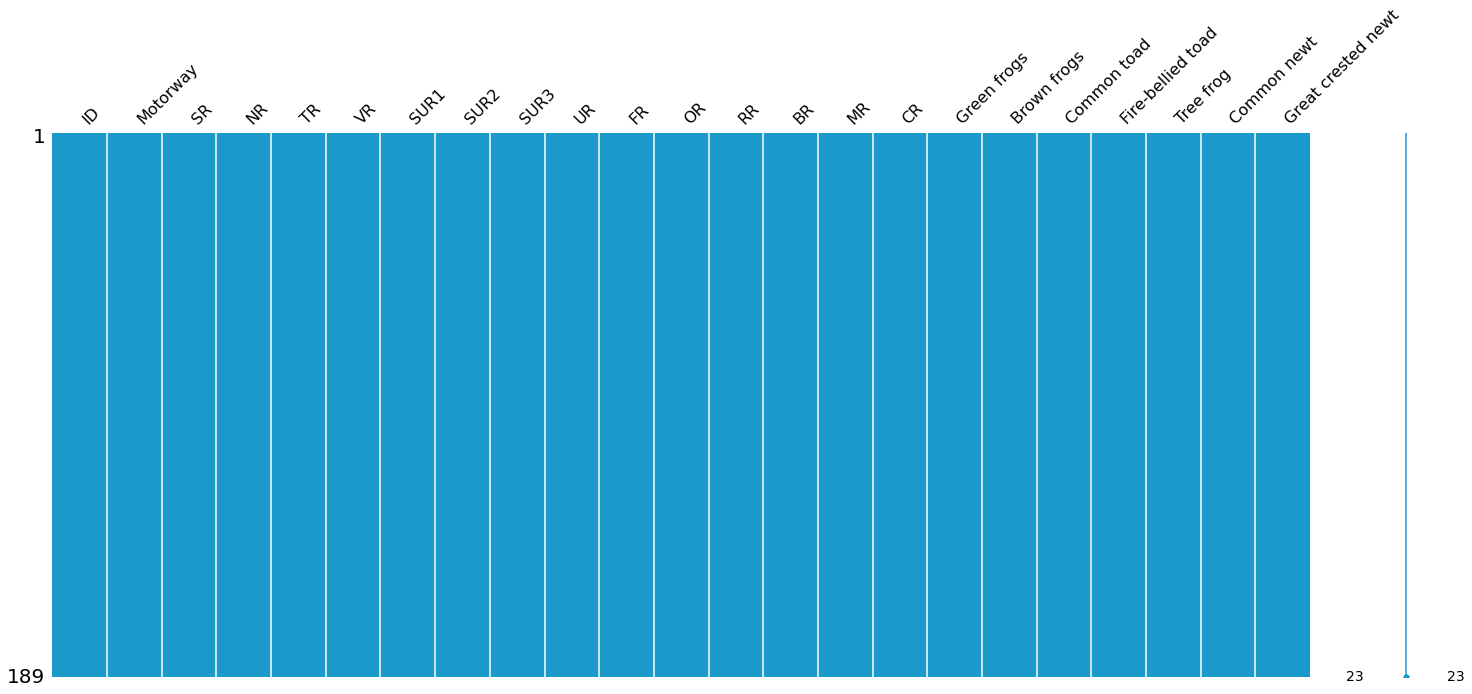

In [4]:
# check missing value 
# 결측치 확인을 위한 plotting을 진행하였고, 확인 결과 결측치는 존재하지 않습니다  
msno.matrix(amphibians.iloc[:, :], color=(0.1, 0.6, 0.8))

In [5]:
# 각 column의 unique value, value 개수를 확인합니다 
# 이로부터 범주형, 연속형, 범주형 중에서도 명목형, 순서형 변수를 확인하고 
# 범주형 변수의 경우 각각이 가지는 class 개수를 확인합니다. (정리된 내용은 상단에 작성)
for c in amphibians.columns : 
    print(c,"(", amphibians[c].nunique(), "): ", amphibians[c].unique())
    print()

ID ( 189 ):  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189]

Motorway ( 2 ):  ['A1' 'S52']

SR ( 66 ):  [   600    700    200    300    500    750   7000   1700   8000  30000
   1600   3800   2500    800   4500   1000   3300   2100    400   1100
    100  80000  31000  25000  400

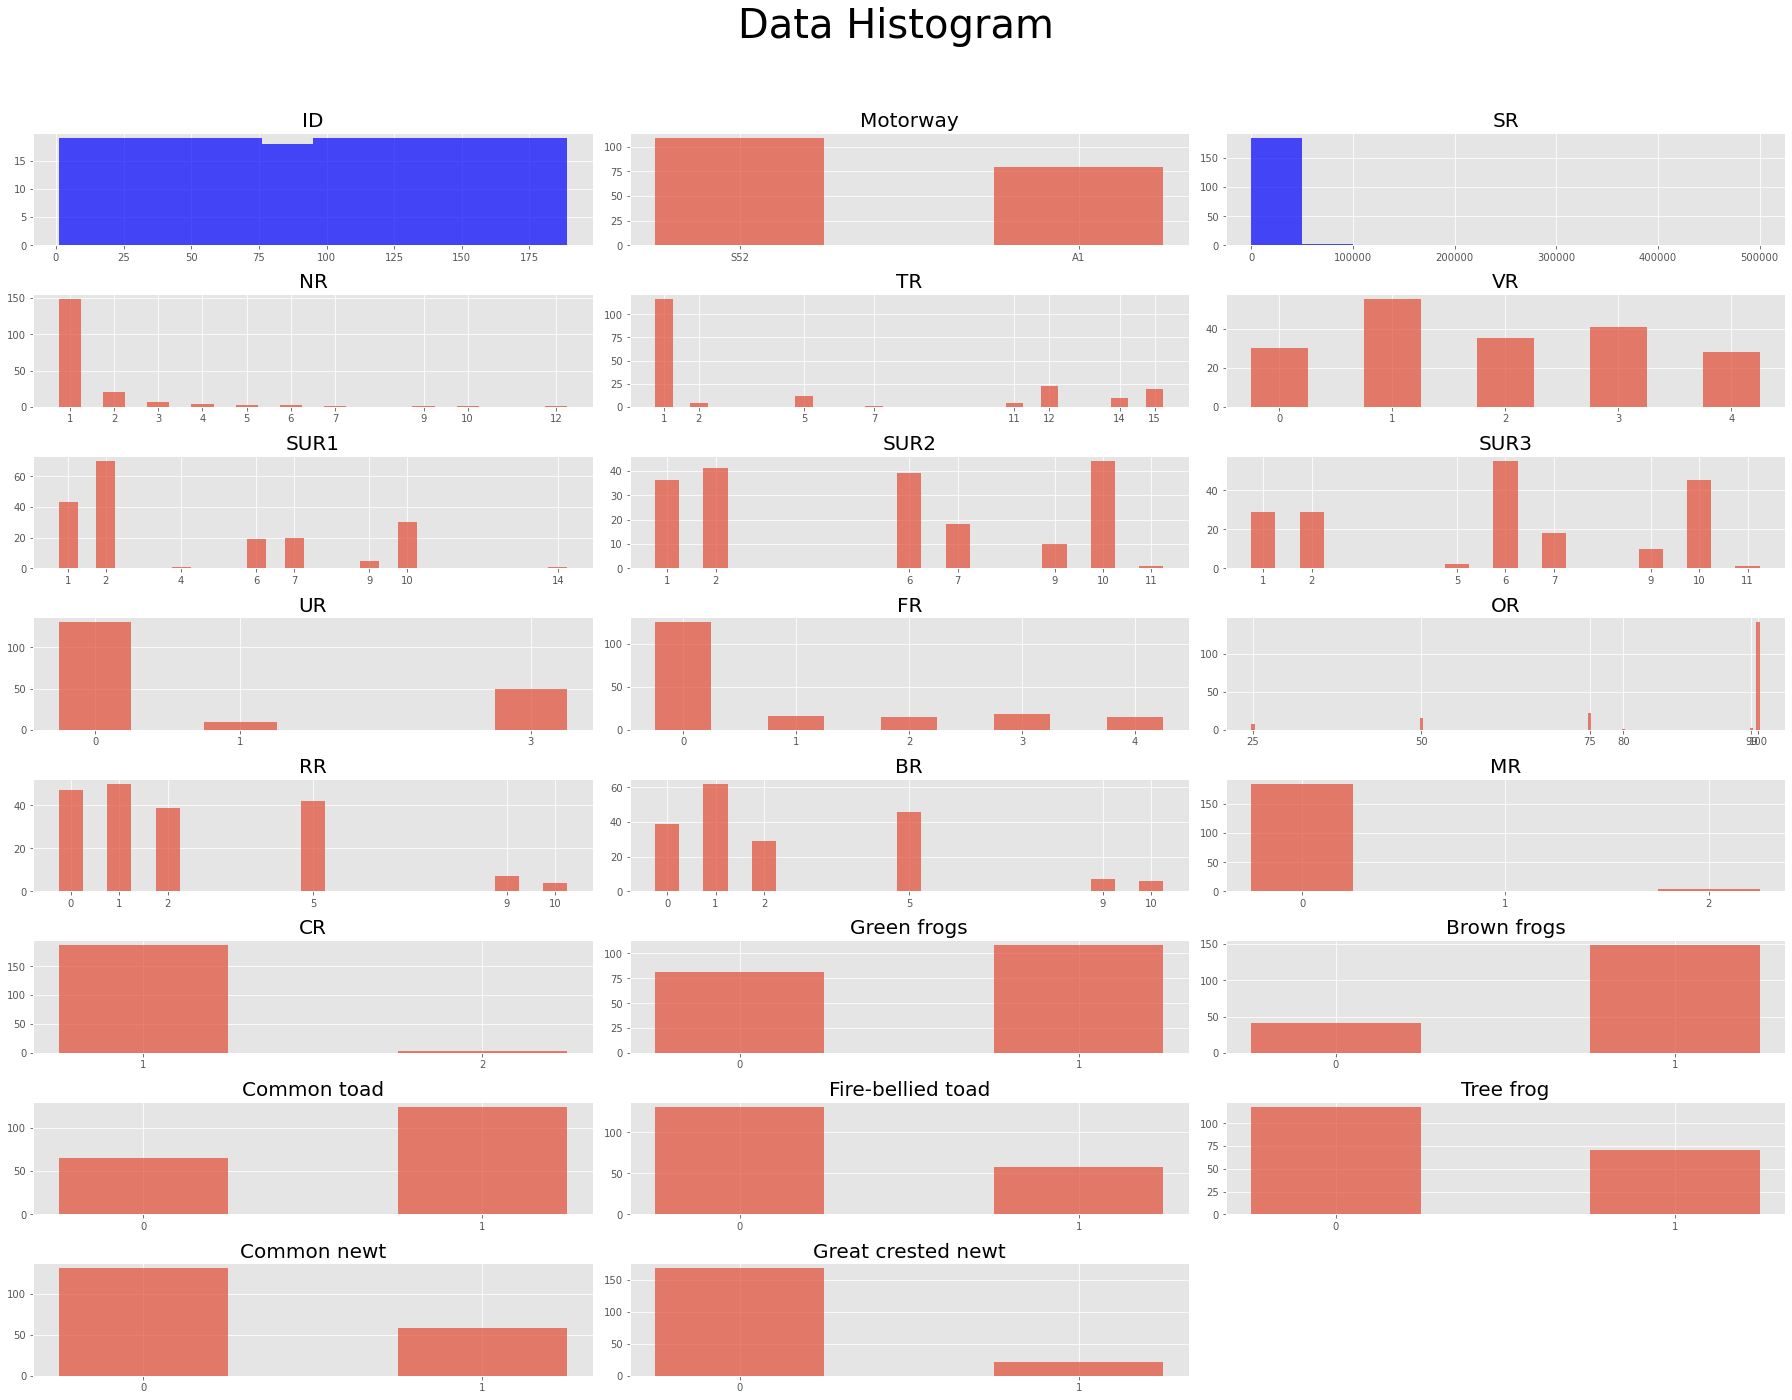

In [6]:
plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,20))
plt.suptitle("Data Histogram", fontsize=40)

cols = amphibians.columns
for i in range(len(cols)):
    plt.subplot(8,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(amphibians[cols[i]].unique()) > 20:
        plt.hist(amphibians[cols[i]], color='b', alpha=0.7)
    else:
        temp = amphibians[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

- SR, 저수지의 표면 숫자는 초반에 값이 몰려있다가 끝에 갈수록 유난히 큰 값들이 존재하는 것 같습니다
- NR, 서식지의 저수지 수 또한 1~2개인 경우가 많고 유난히 많은 곳도 존재하는 것 같습니다
- TR, UR, FR, OR, MR 변수들을 보니 특정 종류의 습지, 지역적 특성 데이터가 많은 것 같습니다, 즉 데이터의 분포가 불균등한 편입니다  
    - 불균등한 변수들 대비 Motorway 고속도로 변수에 대해 비교해보면, 대부분의 고속도로 환경이 비슷하지만 특수한 환경을 가진 곳이 몇 몇 곳 존재한다고 여겨집니다 
    - 이런 특수한 환경적 특성이 양서류의 출현 빈도에 영향을 줄 것 같습니다
- VR, 저수지 내 초목 존재의 유형은 고른 편입니다 
    - 저수지의 초목은 양서류를 선호하고 번식을 촉진하며 유충의 먹이를 공급하고 피난처를 제공한다고 합니다
    - 그러나 고도한 초목은 연못의 과성장과 물 부족으로 이어질 수 있습니다 
- frog 개구리들은 대부분 잘 나타나는 것 같지만 그에 비해 newt 종은 전반적으로 출현 빈도가 낮습니다
    - newt 종이 나타날 정도면 다른 양서류종들도 살기 좋은 편일 수 있습니다 
    - 또는 그 반대로 newt 종과 다른 양서류종들이 원하는 환경이 정반대일 수 있습니다 

# 1.3 Preprocessing

data -> processed_data

189 rows X 23 columns  
**189 rows X 22 columns**

- 결측치 제거 -> **필요 없음** 
- 변수 제거 
    - ID, 식별자 변수 
- 범주형 - 순서형 변수 -> **필요 없음** 
    - RR, BR 
        - <50m, 50 ~ 100m, 100 ~ 200m, 200 ~ 500m, 500 ~ 1000m, >1000m
        - 0, 1, 2, 5, 9, 10 
        - 전처리(labeling)되어 있는 상태 
- 범주형 - 명목형 변수 -> **필요 없음**
    - TR, VR, UR, FR, MR, CR, SUR1, SUR2, SUR3 
    - Green frogs, Brown frogs, Common toad, Fire-bellied toad, Tree frog, Common newt, Great crested newt
        - 전처리(labeling)되어 있는 상태 
- 이상치 생성 

In [40]:
amphibians.columns

Index(['ID', 'Motorway', 'SR', 'NR', 'TR', 'VR', 'SUR1', 'SUR2', 'SUR3', 'UR',
       'FR', 'OR', 'RR', 'BR', 'MR', 'CR', 'Green frogs', 'Brown frogs',
       'Common toad', 'Fire-bellied toad', 'Tree frog', 'Common newt',
       'Great crested newt'],
      dtype='object')

In [56]:
# 전처리를 위해 원본 데이터를 따로 저장합니다 
# 원본 데이터 : data
# 전처리된 데이터 : processed_data

# 불필요한 변수, 식별자 변수는 제거합니다 
processed_data = amphibians.drop(['ID'], axis=1).copy()

범주형 변수에 대하여 숫자형(int)로 변환해주어야 합니다.  
순서성이 있냐 없냐에 따라 쓰이는 Encdoing 방식이 다름으로 주의해야 합니다.  

그러나 해당 데이터셋의 특징상 특정 변수를 제외하고 모든 변수들이 labeling 되어 있는 상태입니다.  
그렇기에 이 점을 감안하여 전처리 과정을 생략할 수 있습니다. 

SR 	 7800.00 	 29 	 -4200.00 	 0
NR 	 1.00 	 41 	 1.00 	 0
OR 	 101.50 	 0 	 97.50 	 46


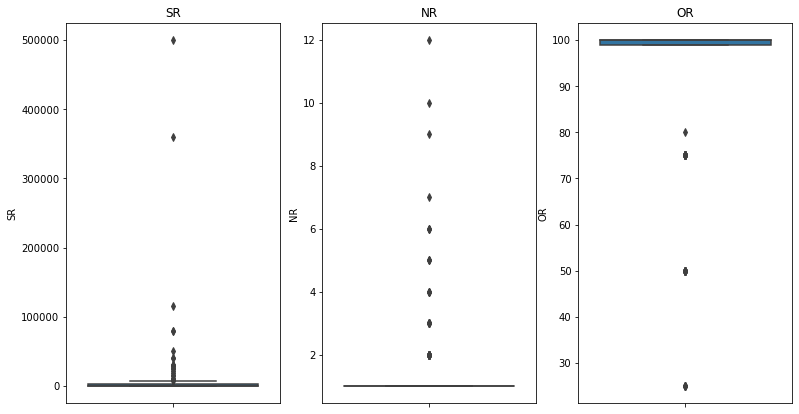

In [57]:
# 연속형 변수에 대해 이상치를 다룰 것 입니다
num_cols = ['SR', 'NR', 'OR']

fig, axes = plt.subplots(1, 3, figsize=(13, 7))

# box plot 상 이상치 개수를 확인하기 위해 upper fence, lower fence 바깥의 관측치를 확인해봅니다 
for c in num_cols :
    Q1 = np.percentile(processed_data[c],25)
    Q3 = np.percentile(processed_data[c],75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    df = processed_data[c]
    print(str(c) , "\t",
          "%.2f \t" % upper_fence, len(df[df > upper_fence]), 
          "\t %.2f \t" % lower_fence, len(df[df < lower_fence]))
    
    sns.boxplot(y=c, data=processed_data, ax=axes[num_cols.index(c)])
    ax=axes[num_cols.index(c)].set_title(str(c))
    
plt.show()

# SR 29 0
# NR 41 0
# OR 0 46 

SR 	 7800.00 	 37 	 -4200.00 	 0
NR 	 1.00 	 47 	 1.00 	 0
OR 	 101.50 	 8 	 97.50 	 46


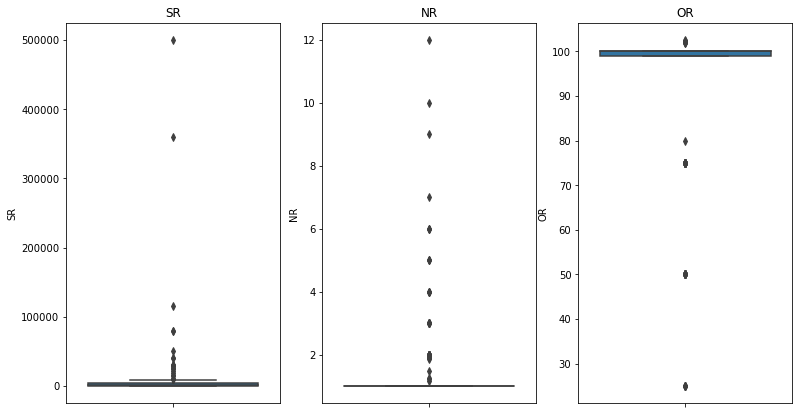

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(13, 7))

random.seed(2)
for c in num_cols:
    Q1 = np.percentile(processed_data[c],25)
    Q3 = np.percentile(processed_data[c],75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)

    outlierNum = round(len(processed_data) * 4 / 100)
    flag = random.choice([True,False])

    for j in range(outlierNum):
        row = random.randrange(0,len(processed_data))
        if flag:
            processed_data[c][row] = upper_fence + random.random()
        else:
            processed_data[c][row] = lower_fence + random.random()
    
    df = processed_data[c]
    print(str(c) , "\t",
          "%.2f \t" % upper_fence, len(df[df > upper_fence]), 
          "\t %.2f \t" % lower_fence, len(df[df < lower_fence]))
            
    sns.boxplot(y=c, data=processed_data, ax=axes[num_cols.index(c)])
    ax=axes[num_cols.index(c)].set_title(str(c))
    
plt.show()

# SR 37 0 
# MR 47 0 
# OR 8 46 

데이터의 연속형 변수에서 존재하는 기존의 이상치를 확인해 본 결과 아래와 같은 개수와 비율로 있음을 확인하였습니다.  

- SR 29 / 189 -> 0.15%
- NR 41 / 189 -> 0.21%
- OR 46 / 189 -> 0.24%

추가적으로 Box plot을 확인하였을 때에도 이상치가 적지 않은 편임을 알 수 있습니다.  
특히 OR 변수는 다른 연속형 변수와 달리 under fence 아래의 이상치가 많이 존재합니다.

기존의 것과 더불어 이상치를 추가적으로 발생시킴으로써 의사결정나무 모델의 가지치기(Pruning)기능의 효과를 확실히 확인할 것입니다. 기존 이상치 개수를 감안하여 대략 3~4%의 이상치를 발생시켰고 최종 이상치 개수는 아래와 같습니다.  

- SR 37 / 189 -> 0.19% (4%)
- NR 47 / 189 -> 0.24% (3%)
- OR 54 / 189 -> 0.28% (4%) 

똑같이 Box plot을 확인해 본 결과 특히나 OR 변수는 upper fence 바깥의 이상치만 발생하였는데 이를 그래프에서도 확인할 수 있으며 이상치가 제대로 생성되었음을 알 수 있습니다. 

In [33]:
# 전처리가 완료되었습니다
processed_data.head()

,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,...,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,A1,600.0,1.0,1,4,6,2,10,0,0,...,0,0,1,0,0,0,0,0,0,0
1,A1,700.0,1.0,5,1,10,6,10,3,1,...,1,0,1,0,1,1,0,0,1,0
2,A1,200.0,1.0,5,1,10,6,10,3,4,...,1,0,1,0,1,1,0,0,1,0
3,A1,300.0,1.0,5,0,6,10,2,3,4,...,0,0,1,0,0,1,0,0,0,0
4,A1,600.0,2.0,1,4,10,2,6,0,0,...,5,0,1,0,1,1,1,0,1,1


# 1.4 Data Split 

processed_data -> input_data_X, input_data_y  
input_data_X -> train_X, test_X  
input_data_y -> train_y, test_y  

**189 rows X 22 columns**

기본적인 전처리가 완료되었습니다.  
이제 학습을 위해서는 데이터를 학습, 테스트 데이터로 분리해야 합니다.  
학습 데이터는 모델의 구축을 위해, 테스트 데이터는 구축된 모델을 평가하기 위해 사용됩니다.  

이때 학습, 테스트 데이터 분리의 비율은 0.7 : 0.3 으로 잡았으며 이에 따른 데이터 개수는 아래와 같습니다. 
- train data : 132
- test data  : 57

In [34]:
# 전처리된 데이터를 따로 저장합니다 
# 전처리된 데이터 : processed_data
# 모델 입력 데이터 : input_data 
# processed_data -> input_data 
input_data = processed_data.copy()

# X 변수들과 y 변수를 따로 저장하여 다루면 용이합니다 
input_data_X = input_data.drop(['Motorway'], axis=1) # X variable
input_data_y = input_data[['Motorway']].copy()       # y variable, true 

In [35]:
# train / test data로 split 
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.3, 
    random_state=5764,
    shuffle = True,
    stratify = input_data_y # Classification 중요 option 
)

여기서 주의해야 할 것은 해당 데이터셋은 Multi-class classification 문제로 정답 변수인 y의 class의 분포가 다를 경우 데이터를 분할할 때 추가 옵션을 주어야 합니다.  
그것이 **stratify** 옵션으로 y 데이터의 분포와 비슷하게 데이터를 분할해줍니다.  

In [36]:
# 분할이 잘 되었는지 확인해봅니다
print(len(train_X), '\n')
print(train_y.value_counts(), '\n')
print(len(test_X), '\n')
print(test_y.value_counts(), '\n')

132 

Motorway
S52         76
A1          56
dtype: int64 

57 

Motorway
S52         33
A1          24
dtype: int64 



In [64]:
train_y['Motorway'].unique()

"['S52' 'A1']"

# 2.1 Classification Tree

의사결정나무(Decision Tree) 모델이란 데이터들이 갖는 속성의 패턴을 예측 가능한 규칙(rule)들의 조합으로 구성하여 분류 과제를 수행하는 지도 학습 알고리즘입니다. Decision boundary 조합으로 분류 또는 예측을 수행하며 규칙 추출(Rule Extraction)관점에서 모델의 정확도뿐 만 아니라 설명력또한 보장하기 때문에 자주 사용되는 알고리즘이라고 볼 수 있습니다. 

우선은 hyper parameter를 조정하지 않은 단순한 의사결정나무 모델을 만들고 결과를 분석합니다.  
그 후 hyper parameter를 조정한 모델과 가지치기를 통해 일반화 성능을 높인 모델과 비교 분석합니다. 

In [151]:
dt_clf = DecisionTreeClassifier(random_state=12)
dt_clf.fit(train_X, train_y) # 학습

DecisionTreeClassifier(random_state=12)

[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]


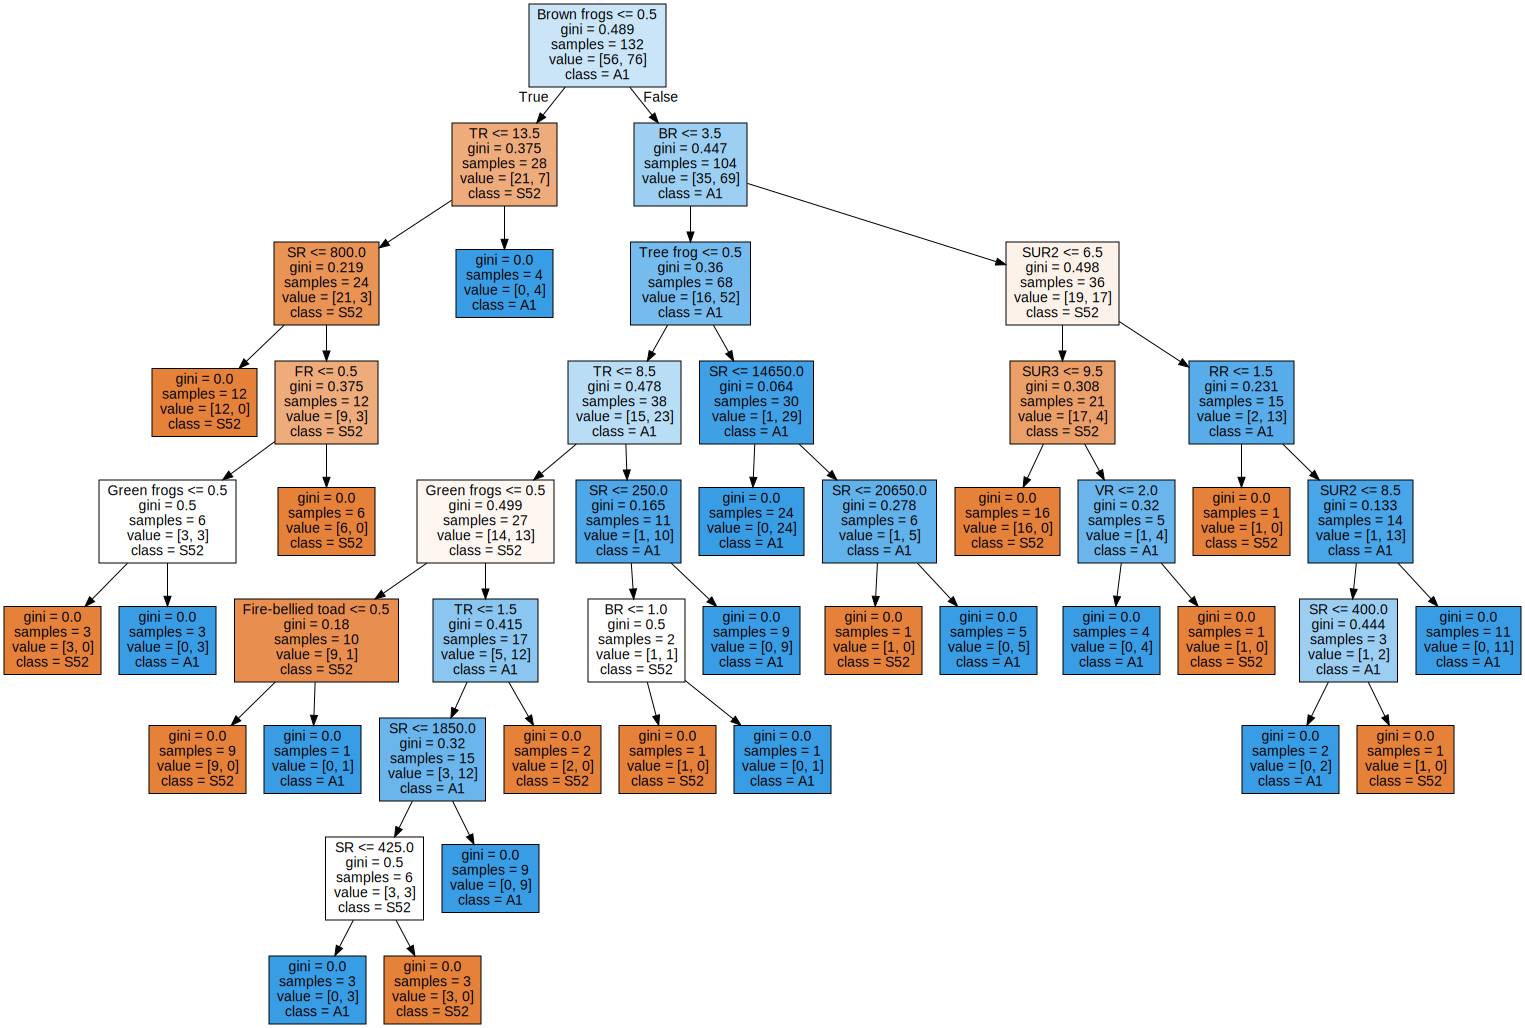

In [152]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(dt_clf, out_file="tree.dot", 
                class_names = train_y['Motorway'].unique(), 
                feature_names = train_X.columns, 
                impurity=True, 
                filled=True)

# Graphviz를 제대로 사용하려면 환경변수 설정과 path 설정을 해주어야 합니다
import os
os.environ["PATH"]+=os.pathsep+'C:/Program Files/Graphviz/bin/'

print('[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

구축된 의사결정나무의 형태를 graphviz library를 통해 plotting 한 결과는 위와 같습니다.  
각 Node에 있는 요소들의 의미는 아래와 같습니다. 

- gini : 다음의 value=[]로 주어진 데이터 분포에서의 지니계수
- samples : 현 규칙에 해당하는 데이터 건수
- value=[] : 클래스 값(y label)에 해당하는 데이터 건수

단순 의사결정나무 모델의 해석은 다음과 같이 정리할 수 있겠습니다.

- 붉은 색 Node : A1 국도 class가 많은 상태
- 파란 색 Node : S52 국도 class가 많은 상태 
- 하얀 색 Node : 두 class의 비율이 거의 절반에 가까운 상태, 불순도가 높은 상태
- Leaf node 까지의 최대 깊이(depth) : 8개 
    - 8번 규칙을 지나면 A1 class의 smaple 3개를 완벽하게 분리해낼 수 있습니다
    - 즉, 최소 두 번(brown frogs가 나타나지 않고, TR이 13.5보다 클 때) 에서 최대 8번의 규칙을 지나면 모든 분류를 해내게 됩니다 
- 1번 dicision rule : Brown frogs가 출현하는가 안하는가
    - 1번 규칙을 지나면 총 132개의 sample을 28개 와 104개로 분리해낼 수 있습니다 
    - Brown frogs의 출현 가능성은 예측에 있어 큰 영향을 주는 것 같습니다
- 불순도가 높은 상태에서(지니 계수 0.5에 가까운) 판단의 요인이 되는 변수들 
    - Green frogs, Brown frogs, SUR2, SUR3, SR
    - 해당 변수들은 어떤 국도인지 예측하는 데에 큰 영향을 준는 것으로 보여집니다 
    - 즉, y 변수에 대한 영향력이 높은 변수들이라고 볼 수 있습니다 
- 의사결정나무는 지니계수를 떨어뜨리는 방향으로 학습함
    - 그러나 오히려 분할이후 지니계수가 높아지는 경우도 존재하곤 합니다 
    - 그렇지만 결국엔 해당 모델은 이진 분류이기에 결국 지니계수는 0.5 ~ 0 사이를 유지합니다 
- 일반적으로 분할된 두 Node 중 sample의 수가 더 많은 곳이 더 많은 node를 뻗어감 
    - 그러나 우측 branch의 경우 그렇지 않은 경우가 존재합니다 
    - 이는 우측 branch에 있는 rule들에서 나눠지는 값들은 예측하기 어려운 값이며 
    - train data에 과적합되기 위해 불필요하게 학습을 많이 하는 경향이 보이는 곳이라고 볼 수 있습니다 
- Leaf node에 모인 관측치들은 동일한 특성을 가짐
    - leaf node에는 반드시 1개의 관측치만 존재하는 것이 아니며 구축된 모델의 경우 12개의 관측치가 같은 특성을 가지는 경우도 존재합니다 

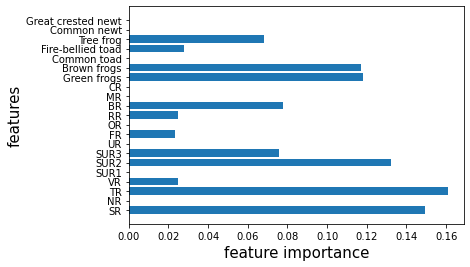

In [153]:
# plotting feature importance 
feature_imp = dt_clf.feature_importances_
n_feature = train_X.shape[1]
idx = np.arange(n_feature)

plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, train_X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('features', size=15)

plt.show()

해석이 맞았는지를 비교하기 위해서 eature importance를 plotting 해보았습니다.  
대체로 맞는 해석임을 알 수 있으며 그만큼 의사결정나무의 해석력이 쉽게 될 수 있음을 알 수 있습니다. 

### prediction

Simple Classfication Tree prediction score 

- accuracy **0.75**
    - 정확도, 가장 직관적인 classification 평가 지표 
- recall **0.75**
    - 재현율, 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율 
- precision **0.75**
    - 정밀도, 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율 
- f1_score **0.75**
    - 조화평균, precision과 recall의 조화평균
- matrix 
    - 15 9 
    - 5 28 

In [154]:
def prediction_score(true_y, pred_y) :
    accuracy = mt.accuracy_score(true_y, pred_y)
    recall = mt.recall_score(true_y, pred_y, average='micro')
    precision = mt.precision_score(true_y, pred_y, average='micro')
    f1_score = mt.f1_score(true_y, pred_y, average='micro')
    matrix = mt.confusion_matrix(true_y, pred_y)
    
    print('Accuracy: ', format(accuracy,'.2f'))
    print('Recall: ', format(recall,'.2f'))
    print('Precision: ', format(precision,'.2f'))
    print('F1_score: ', format(f1_score,'.2f'))
    print('Confusion Matrix:','\n', matrix)

In [155]:
# Prediction
pred_dt = dt_clf.predict(test_X) 

# 학습결과 평가
print("Train_Accuracy : ", dt_clf.score(train_X, train_y))
print("Test_Accuracy : ", dt_clf.score(test_X, test_y), '\n')
prediction_score(test_y, pred_dt)

Train_Accuracy :  1.0
Test_Accuracy :  0.7543859649122807 

Accuracy:  0.75
Recall:  0.75
Precision:  0.75
F1_score:  0.75
Confusion Matrix: 
 [[15  9]
 [ 5 28]]


의사결정나무 모델은 최대한 train data에 과적합되도록 학습하기 때문에 train accuracy가 1.0 이 나올 수 있습니다.    
그렇기에 상대적으로 test data에 대한 accuracy가 떨어집니다.  

특별히 다른 hyperparameter 튜닝을 하지 않은 상태에서의 의사결정나무모델은 0.75의 accuracy를 보이고 있습니다.  
이제 이를 가지치기(pruning)와 hyperparameter 튜닝을 통해 어느정도 까지 성능 향상을 보일 수 있는지 실험할 것 입니다. 

# 2.2 Pruning Phase

의사결정모델이 적당한 일반화 성능을 갖추기 위해서 train data를 비교적 많이 틀리더라도 test data를 좀 더 맞추게 하는 것을 가지치기(Pruning)라고 합니다. 이는 학습모델을 만드는 근본적인 이유인 새로운 데이터 셋에 대한 prediction accuracy를 높이기 위해서 활용되는 hyperparameter의 일종인 기능이라고 볼 수 있습니다.  

In [156]:
# 일반 모델에서 max_depth가 8까지 나왔기 때문에 절반인 4로 조정해보겠습니다 
pruned_dt_clf = DecisionTreeClassifier(max_depth=4, random_state=12) 
pruned_dt_clf.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=4, random_state=12)

[ max_depth = 4, Decision Tree 시각화 ]


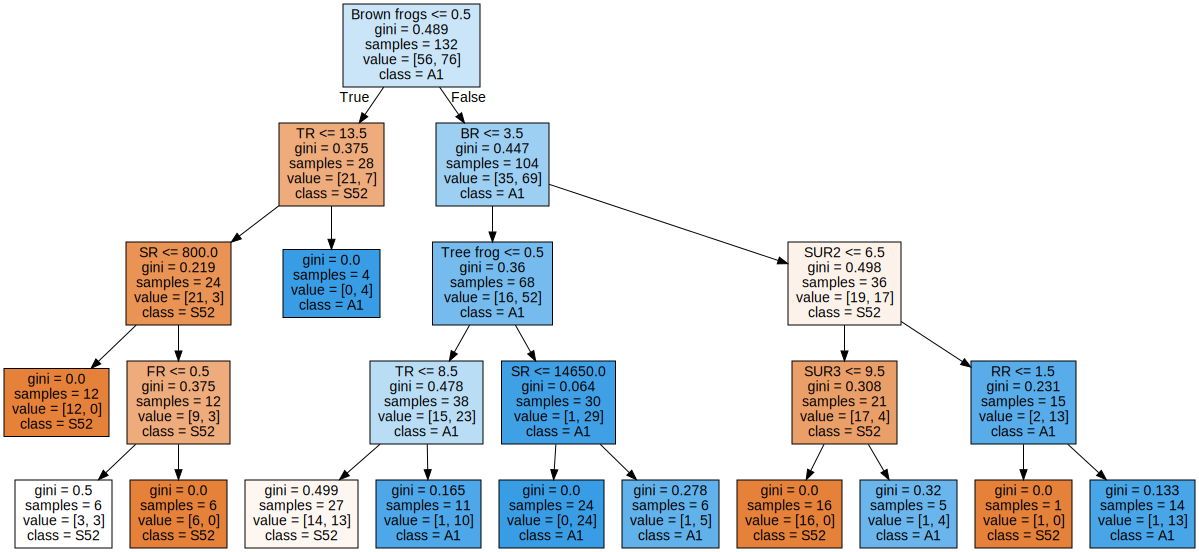

In [157]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(pruned_dt_clf, 
                out_file="prunedtree.dot", 
                class_names = train_y['Motorway'].unique(), 
                feature_names = train_X.columns, 
                impurity=True, 
                filled=True)

print('[ max_depth = 4, Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("prunedtree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

앞서 가지치기를 진행하지 않은 모델과 비교하였을 때 leaf node 까지의 거리가 4이상인 branch들은 모두 삭제된 것을 확인할 수 있습니다.  
이렇게 될 경우 불순도가 높은 leaf node가 2개나 존재하기 때문에 train data에 대한 정확도는 확연히 떨어질 것으로 예측됩니다. 

### prediction

Pruned Classfication Tree prediction score 

- accuracy **0.74**
    - 정확도, 가장 직관적인 classification 평가 지표 
- recall **0.74**
    - 재현율, 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율 
- precision **0.74**
    - 정밀도, 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율 
- f1_score **0.74**
    - 조화평균, precision과 recall의 조화평균
- matrix 
    - 17 7 
    - 8 25 

In [158]:
# Prediction
pred_pruned = pruned_dt_clf.predict(test_X) 

# 학습결과 평가
print("Train_Accuracy : ", pruned_dt_clf.score(train_X, train_y))
print("Test_Accuracy : ", pruned_dt_clf.score(test_X, test_y), '\n')
prediction_score(test_y, pred_pruned)

Train_Accuracy :  0.8484848484848485
Test_Accuracy :  0.7368421052631579 

Accuracy:  0.74
Recall:  0.74
Precision:  0.74
F1_score:  0.74
Confusion Matrix: 
 [[17  7]
 [ 8 25]]


두 개의 모델을 비교한 결과는 다음과 같이 정리할 수 있습니다. 

- train accuracy 하락 
    - 가지치기를 통해 model이 train data에만 과적합되는 것을 방지하였기에 train accuracy가 1.0에서 0.84까지 하락하였습니다
- test accuracy 변화 
    - test accuracy는 0.75에서 0.74까지 약간의 하락을 보이고 있습니다 
    - 그렇다면 train에 과적합되지 않으면서 test data에 대한 accuracy도 어느정도 보장할 수 있는 최적의 hyperparameter를 찾는 것이 관건이 될 것 입니다 

### Optimal Hyperparameter with GridSearchCV

In [159]:
grid_dt_clf = DecisionTreeClassifier(random_state = 12)
parameters = {'splitter' : ['best', 'random'],
              'max_depth' : [4, 5, 6, 7],
              'min_samples_split' : [2, 3, 4, 5, 6]}

dt_grid = GridSearchCV(grid_dt_clf, param_grid = parameters, cv = 5)
dt_grid.fit(train_X, train_y)

result = pd.DataFrame(dt_grid.cv_results_['params'])
result['mean_test_score'] = dt_grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False).head()

,max_depth,min_samples_split,splitter,mean_test_score
36,7,5,best,0.721083
34,7,4,best,0.721083
21,6,2,random,0.719088
32,7,3,best,0.713390
30,7,2,best,0.713390


### prediction

Optical Hyperparameter Classfication Tree prediction score 

- accuracy **0.75**
    - 정확도, 가장 직관적인 classification 평가 지표 
- recall **0.75**
    - 재현율, 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율 
- precision **0.75**
    - 정밀도, 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율 
- f1_score **0.75**
    - 조화평균, precision과 recall의 조화평균
- matrix 
    - 15 9 
    - 5 28 

In [161]:
opt_dt_clf = DecisionTreeClassifier(max_depth = 7,
                                    min_samples_split = 5,
                                    splitter = 'best',
                                    random_state = 12)
opt_dt_clf.fit(train_X, train_y)

# Prediction
pred_opt = opt_dt_clf.predict(test_X) 

# 학습결과 평가
print("Train_Accuracy : ", opt_dt_clf.score(train_X, train_y))
print("Test_Accuracy : ", opt_dt_clf.score(test_X, test_y), '\n')
prediction_score(test_y, pred_opt)

Train_Accuracy :  0.9621212121212122
Test_Accuracy :  0.7543859649122807 

Accuracy:  0.75
Recall:  0.75
Precision:  0.75
F1_score:  0.75
Confusion Matrix: 
 [[15  9]
 [ 5 28]]


hyperparameter를 튜닝하는 방법은 여러 가지가 있을 수 있지만 이번에는 sklearn에서 제공하는 GridSearchCV를 이용하였습니다. 

최적의 hyperparameter로 설정된 모델에 대해서 예측 정확도를 확인해 본 결과,  
train data에 대해서는 0.96, test data에 대해서는 0.75의 정확도를 보이고 있습니다.  

이는 아무런 튜닝을 하지 않은 모델에서도 test data에 대한 정확도는 똑같이 보이고 있지만  
train data에 대해서는 정확도가 떨어진 것으로, 과적합을 상대적으로 피하고 있음을 알  수 있습니다.  

이때 가지치기한 모델과 비교하였을 때
가지치기 모델의 max depth는 4, 최적의 hyperparameter 튜닝을 거친 모델의 max depth는 7로  
train data에 대한 정확도가 가지치기 모델이 더 낮을 수 밖에 없음을 알 수 있으며  
일반화 성능면에서는 가지치기 모델이 좀 더 좋을 수 있을거라 예상되지만,  
이에 대해서는 더 많은 데이터셋에 대해 비교해보아야 확실히 알 수 있을거라 생각됩니다.  

# 2.3 Conclusion

의사결정나무를 다양하게 실험, 분석하였고 이 과정에서 느낀 의사결정나무의 특징을 서술하면 다음과 같이 정리할 수 있습니다. 

- **과적합 발생 문제** 
    - 과적합 발생이 쉽다 
    - 이를 극복하기 위해서는 트리의 최대 깊이와 각 노드가 가질 수 있는 최소 샘플 개수 등의 hyperparameter 튜닝이 필요하다
    - 그러나 이는 동시에 hyperparameter 튜닝에 민감하다는 의미가 될 수 있다 
    - 특히나 sample size가 적을 때 더 신중한 튜닝이 필요하다고 여겨진다 
- **예측 성능면에서의 손실** 
    - 의사결정나무는 여러 개의 값들이 하나의 class일 때 같은 정답으로 예측한다 
    - 이는 여러 개의 값 각각이 가지는 분산과 편차를 고려하지 않는다 
    - 즉, leaf node 끝에 값들이 모두 같은 하나의 예측값을 가지게 되는 것은 각각의 값들이 가지는 차이를 하나로 묶어서 본다는 것이다 
    - 이로부터 예측 성능면에서의 손실이 발생한다고 생각한다 
- **결측치와 이상치** 
    - 예측 성능면에서는 손실이 있을 수 있지만 반대로 결측치와 이상치에는 덜 민감한 편이다 
    - 예측값의 분산을 신경쓰지 않고 자료의 형태와 상관없이 오로지 순위적인 측면을 통해서만 규칙(rule)을 만들고 분류하기에 이상치에 민감하지 않다 
    - 그러나 의사결정회귀나무에서는 변수의 평균을 가지고 예측값을 추정해 가기 때문에 오히려 이상치에 영향을 받을 수 있을 것이라 생각한다 
- **변수간 상호작용** 
    - 결정트리는 하나의 변수만을 고려하여 분류를 진행하기 때문에 변수간 상호작용을 파악하기는 어렵다 
    - 그렇기 때문에 만약 상관관계가 높은 두 변수에 대해서 어떤 변수를 먼저 규칙의 기반으로 사용하냐에 따라 트리의 모양이 달라질 수 있다 
    - 즉 변수 선택에 따라 최적해가 달라질 수 있다 
- **분기점을 통한 특성의 성질 파악**
    - 결정트리는 계속되는 분기점을 통해서 leaf node의 불순도가 0이 될 때 분기를 종료한다 
    - 이는 leaf node에 모인 관측치들은 비슷한 유형과 특성을 가지고 있음을 알 수 있다 
    - 이로부터 착안하여 의사결정트리를 이용해 segmetation(분할)해가면서 이상치와 결측치 부분을 찾아가는 solution들도 존재하고 있다